# Popular Items sold last year #

In [2]:
from config.config import CONFIGURATION_PATH
import utils.images_utils as hlpimage
from matplotlib import pyplot as plt
import utils.write_utils as hlwrite
import utils.read_utils as hlpread
from os.path import exists
import cv2
import os
import gc

In [7]:
current_dir = os.path.dirname(os.path.realpath('__file__'))
PROJECT_ROOT = os.path.abspath(os.path.join(current_dir, os.pardir))

while os.path.exists(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH)) == False:

    PROJECT_ROOT = os.path.abspath(os.path.join(PROJECT_ROOT, os.pardir))

#PROJECT_ROOT

In [9]:
TRANSACTION_DATA = os.path.join(PROJECT_ROOT, 
                                hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','data_folders'),
                                hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','processed_data_folder'),
                                hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'data_source','clean_transaction_data'),
                                )

tran_data = hlpread.read_from_parquet(TRANSACTION_DATA)

max_t_date = tran_data.t_dat.max()
min_t_date = tran_data.t_dat.min()

print(f'Transaction records from: {min_t_date} to {max_t_date}')

Transaction records from: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [11]:
tran_data.head()

,t_dat,customer_id,article_id,price,online_sale,unique_transaction_id
0,2018-09-20,-6846340800584936,541518023,0.030492,True,0
1,2018-09-20,-8334631767138808638,505221004,0.015237,True,1
2,2018-09-20,-8334631767138808638,685687003,0.016932,True,2
3,2018-09-20,-8334631767138808638,685687004,0.016932,True,3
4,2018-09-20,-8334631767138808638,685687001,0.016932,True,4


In [16]:
#Items that are sold every year in month same as we have in validation dataset
def week_number_of_month(date_value):
     return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)  

tran_data['month'] = tran_data.t_dat.dt.month
tran_data['year'] = tran_data.t_dat.dt.year
tran_data['week_of_month']  = tran_data.t_dat.apply(week_number_of_month)

items_sold_year = tran_data[tran_data.month.isin([9,10])].groupby(['article_id','year'])
item_sold_more_then_year = {}

previous_item_id = 0
sold_years = []
for item_id, year in items_sold_year.groups:
    
    if previous_item_id == 0:    
        
        previous_item_id = item_id
        
        if item_id not in item_sold_more_then_year:
            item_sold_more_then_year[item_id] = []
        
    elif previous_item_id != item_id:
        
        if len(sold_years) > 1:
            item_sold_more_then_year[previous_item_id] = sold_years
        previous_item_id = item_id
        sold_years = []
    
    sold_years.append(year)
    
#item_sold_more_then_year

In [17]:
grp = (tran_data[tran_data.article_id.isin(item_sold_more_then_year.keys()) & 
             tran_data.month.isin([9,10])]
       [['article_id','year','month','week_of_month']]
       .drop_duplicates()
       .sort_values(['article_id','year','month'])
       )

#Are there similarity in the items that was purchase in same month in last years

item_sold_9_month_2019 = set(grp[(grp.month == 9) & (grp.year == 2019)].article_id)
print(f' Number of items sold in 9th month of year 2019: {len(item_sold_9_month_2019)}')

item_sold_9_month_2020 = set(grp[(grp.month == 9) & (grp.year == 2020)].article_id)
print(f' Number of items sold in 9th month of year 2020: {len(item_sold_9_month_2020)}')


print('='*60)

print(f'Number of same items sold in 9th month of year 2019 and 2020: {len(item_sold_9_month_2020.intersection(item_sold_9_month_2019))}')


del grp
gc.collect()

 Number of items sold in 9th month of year 2019: 12942
 Number of items sold in 9th month of year 2020: 7359
Number of same items sold in 9th month of year 2019 and 2020: 6435


0

**Observations:**

1. Items that are max sold are items that are sold every year.
2. There are items what are sold every year different month or same month. 
3. This can be helpfull to generate the candinate for our validation data set for same month.

List out items that are sold in same month as validation data in previous years which we can recommend this year.

In [18]:
#Recomend item that was sold max last year at same month and year in same week or next week
vc = tran_data[(tran_data.year == 2019) & 
           (tran_data.month == 9) & 
           (tran_data.week_of_month.isin([5,6]))
          ].article_id.value_counts() 

pairs_items = {}
for item ,item_count in zip(vc.index, vc.values):

    #Only consider those items which where sold more then once
    if item_count > 1:
        pairs_items[item] = item_count      



In [30]:
import utils.write_utils as hlwrite
POPULAR_ITEMS_LAST_YEAR = os.path.join(PROJECT_ROOT, 
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'model', 'output_folder'),
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'candidate-popular-items-last-year', 'popular-items-last-year-folder'),
                                        hlpread.read_yaml_key(os.path.join(PROJECT_ROOT, CONFIGURATION_PATH),'candidate-popular-items-last-year', 'popular-items-last-year-output'),
                                        )

hlwrite.save_object(POPULAR_ITEMS_LAST_YEAR, pairs_items)
#POPULAR_ITEMS_LAST_YEAR


## Display items that are sold ##

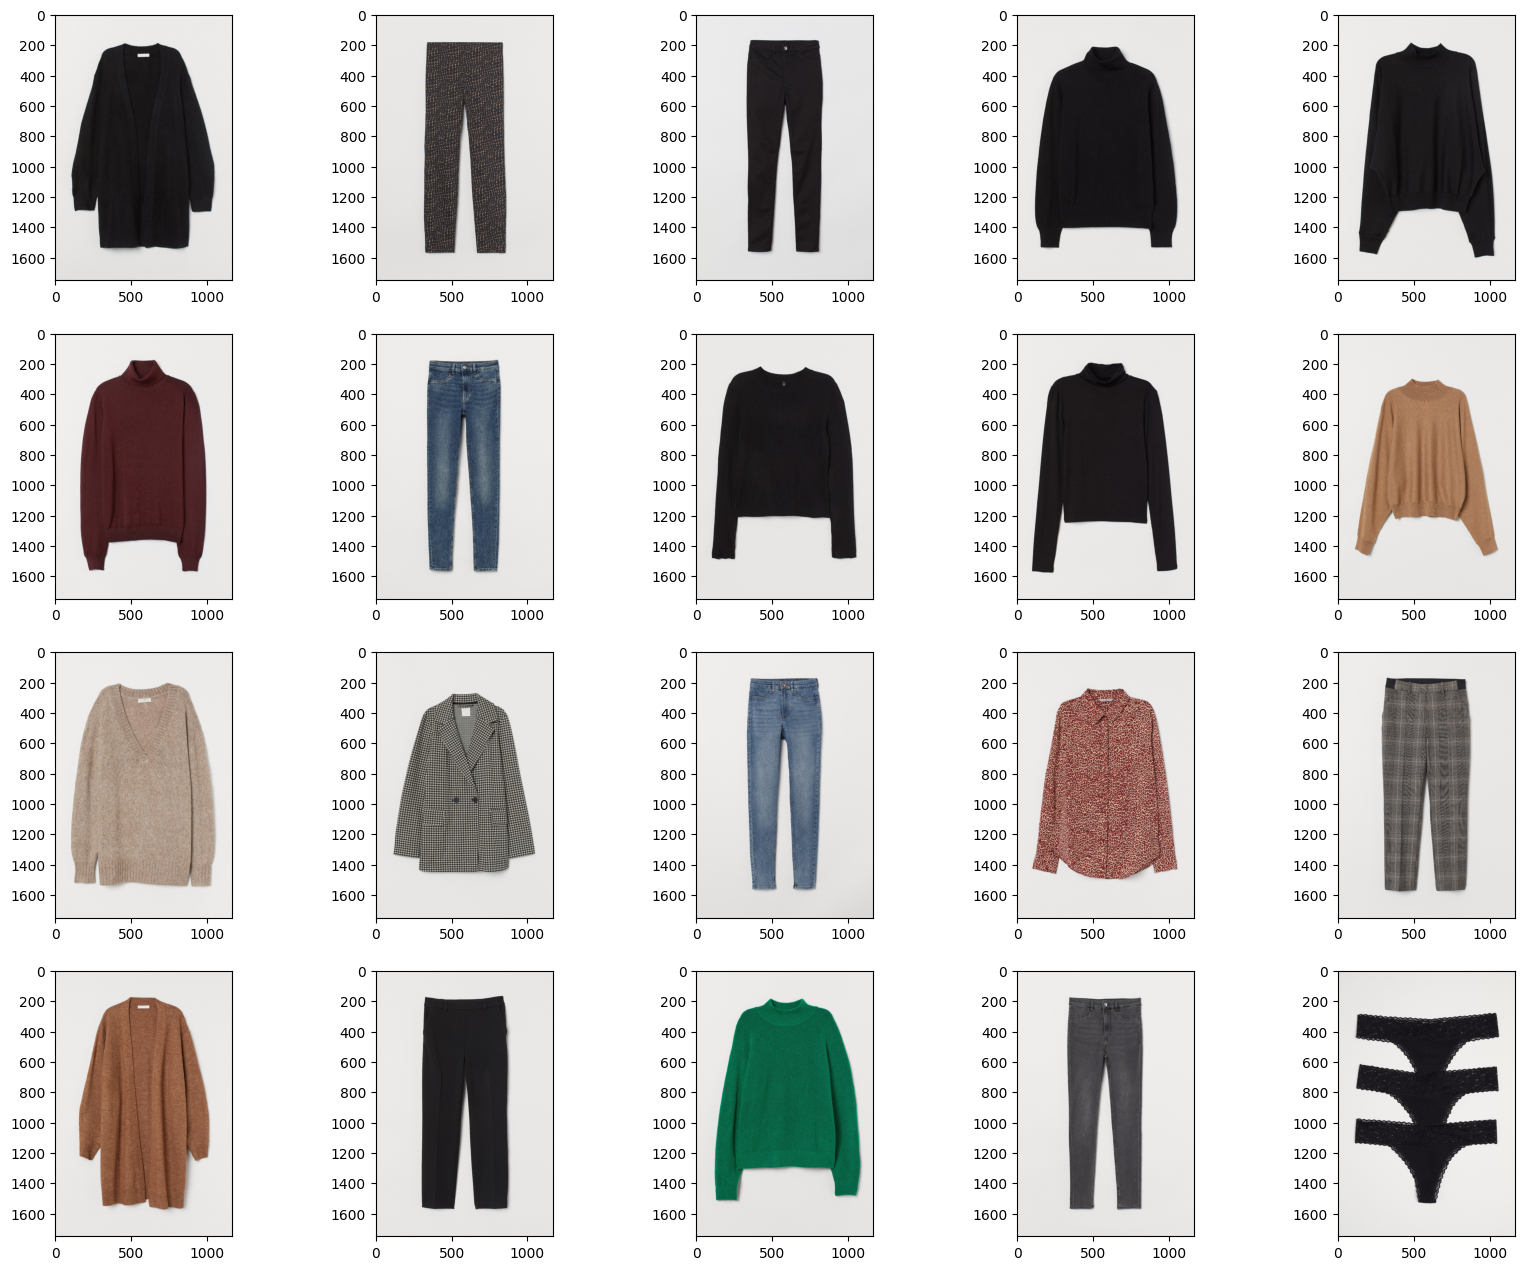

In [7]:
top_item = list(pairs_items.keys())[:20]

plt.figure(figsize=(20,20))

for idx, k in enumerate( top_item ):

    name = hlpimage.get_image_path(k)    
    if exists(name) :
        plt.subplot(5, 5, idx + 1 )        
        img = cv2.imread(name)[:,:,::-1]
        plt.imshow(img)
        
plt.show()

**Observartion**
Looking at images it look like winter wear purchase